# Ensemble Model

# Installations

In [ ]:
! pip install virtualenv


In [ ]:
! virtualenv env

In [ ]:
! source env/bin/activate

In [ ]:
!pip install transformers[tf-cpu]

In [ ]:
!pip install datasets

In [ ]:
!pip install tensorflow-gpu==2.10

## Loading Data and Partitioning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
import tensorflow as tf
import transformers as tr
import PIL as PIL
from PIL import ImageFile
import os


import datetime
import datasets

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pandas as pd
import numpy as np
#metadata
metadata = pd.read_csv('/content/drive/MyDrive/Github/ece539-metamushroom-project/data/DF20M-train_metadata_PROD_edibility.csv')
sample = metadata[['image_path', 'edibility', 'month', 'Substrate', 'Habitat', 'species']].dropna()
DATA_DIR = '/content/drive/MyDrive/Github/ece539-metamushroom-project/data/images/DF20M/'


In [ ]:
from sklearn.model_selection import train_test_split

Xs = sample[['image_path', 'edibility', 'month', 'Substrate', 'Habitat']]
ys = sample[['species']]

Xs_, Xs_test, ys_, ys_test = train_test_split(Xs, ys, test_size=0.2, stratify = ys, random_state=42)
Xs_train, Xs_sample, ys_train, ys_sample = train_test_split(Xs_, ys_, test_size = 0.8, stratify = ys_, random_state = 42)
Xstr, Xste, ystr, yste = train_test_split(Xs_train, ys_train, test_size = 0.2, stratify = ys_train, random_state = 42)

In [ ]:
len(Xstr), len(Xste)

(4161, 1041)

In [ ]:
month = Xstr['month'].to_numpy()
substrate = Xstr['Substrate'].factorize()[0]
habitat = Xstr['Habitat'].factorize()[0]

Xtr = np.vstack([month, substrate, habitat]).T
ytr = Xstr['edibility'].to_numpy()

month = Xste['month'].to_numpy()
substrate = Xste['Substrate'].factorize()[0]
habitat = Xste['Habitat'].factorize()[0]

Xte = np.vstack([month, substrate, habitat]).T
yte = Xste['edibility'].to_numpy()

In [ ]:
Xtr, Xval, ytr, yval =  train_test_split(Xtr, ytr, test_size = 0.15, stratify = ytr, random_state = 42)

## Decision Tree Pre-classifier

#### Model selection - hyperparameter tuning

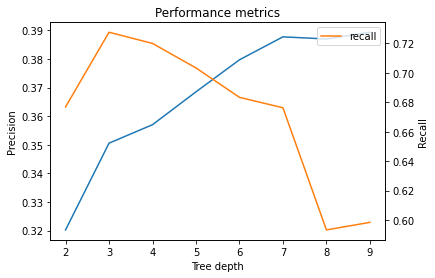

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score


kf = KFold(n_splits=5)

#aucs_roc = np.zeros((5,8))
#aucs_pr = np.zeros((5,8))
aps_pr = np.zeros((5,8))
aps_re = np.zeros((5,8))
n = 0

for train_index, test_index in kf.split(Xtr):
  #auc_roc = np.zeros((8,))
  #auc_pr = np.zeros((8,))
  ap_pr = np.zeros((8,))
  ap_re = np.zeros((8,))
  X_train, X_test = Xtr[train_index], Xtr[test_index]
  y_train, y_test = ytr[train_index], ytr[test_index]

  depths = [2,3,4,5,6,7,8,9]
  for i, depth in enumerate(depths): 
    clf = DecisionTreeClassifier(random_state=0, criterion = 'gini',min_samples_leaf = 10, class_weight = 'balanced', max_depth=depth)
    clf.fit(X_train, y_train)
  
    y_pred = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 1)

    #auc_roc[i] = metrics.auc(fpr, tpr)
    #auc_pr[i] = metrics.auc(recall, precision)
    ap_pr[i] = metrics.average_precision_score(y_test, y_pred, pos_label = 1)
    ap_re[i] = metrics.recall_score(y_test, np.array(y_pred > 0.5, dtype = 'int'), pos_label = 1)

  #aucs_roc[n, :] = auc_roc
  #aucs_pr[n, :] = auc_pr
  aps_pr[n, :] = ap_pr
  aps_re[n, :] = ap_re
  n += 1

#print(np.mean(aucs_pr, axis = 0))
#print(np.mean(aucs_roc, axis = 0))
#print(np.mean(aps_pr, axis = 0))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()


ax1.plot(depths, np.mean(aps_pr, axis = 0), color = '#1f77b4', label = 'precision')
ax2.plot(depths, np.mean(aps_re, axis = 0), color = '#ff7f0e', label = 'recall')
ax1.set_xlabel('Tree depth')
ax1.set_ylabel('Precision')
ax2.set_ylabel('Recall')
plt.title('Performance metrics')
plt.legend()
plt.show()

In [ ]:
#testing
clf = DecisionTreeClassifier(random_state=0, criterion = 'entropy', min_samples_leaf = 10, class_weight = 'balanced', max_depth=6)
clf.fit(Xtr, ytr)
y_pred = clf.predict_proba(Xval)[:, 1]

precision, recall, proba = metrics.precision_recall_curve(yval, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred, pos_label = 1)

#*auc_roc = metrics.auc(fpr, tpr)
auc_pr = metrics.auc(recall, precision)

print(auc_pr)
#print(precision)
#print(proba[np.argsort(precision)[0]])

0.40075566339182883


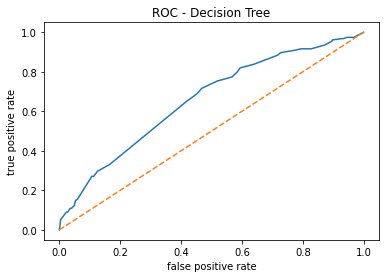

In [ ]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')
plt.title("ROC - Decision Tree")
plt.xlabel("false positive rate")
plt.ylabel('true positive rate')
plt.show()

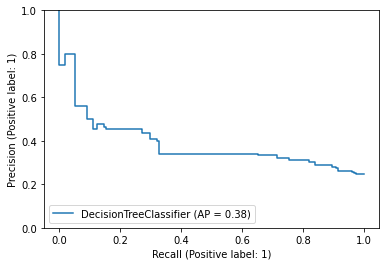

In [ ]:
metrics.PrecisionRecallDisplay.from_estimator(clf, Xval, yval)
plt.ylim([0,1])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(Xval)
y_true = yval
confusion_matrix(y_true, y_pred)

array([[225, 245],
       [ 38, 117]])

We want to minimize False Positives while still not classifying everything as Negative -- this gives us the second threshold.

This is the "highest" point on the curve except (0,1). 

In [ ]:
for i in np.unique(clf.apply(Xtr)): 
  data_labels_train = ytr[np.where(clf.apply(Xtr) == i)[0]]
  data_labels_val = yval[np.where(clf.apply(Xval) == i)[0]]
  print("Node {0} Proportion positive/edible: train: {1} (total: {2}), val: {3} (total: {4})".format(i, np.round(np.sum(data_labels_train) /len(data_labels_train), 2), 
                                                                                                    len(data_labels_train), 
                                                                                                    np.round(np.sum(data_labels_val) /len(data_labels_val), 2), len(data_labels_val)))

Node 6 Proportion positive/edible: train: 0.54 (total: 90), val: 0.4 (total: 15)
Node 7 Proportion positive/edible: train: 0.31 (total: 13), val: 0.0 (total: 2)
Node 9 Proportion positive/edible: train: 0.78 (total: 18), val: nan (total: 0)
Node 10 Proportion positive/edible: train: 0.5 (total: 10), val: 0.33 (total: 3)
Node 13 Proportion positive/edible: train: 0.59 (total: 32), val: 0.83 (total: 6)
Node 14 Proportion positive/edible: train: 0.44 (total: 198), val: 0.45 (total: 38)
Node 16 Proportion positive/edible: train: 0.17 (total: 53), val: 0.43 (total: 7)
Node 17 Proportion positive/edible: train: 0.44 (total: 34), val: 0.25 (total: 4)
Node 21 Proportion positive/edible: train: 0.28 (total: 977), val: 0.29 (total: 170)
Node 22 Proportion positive/edible: train: 0.5 (total: 44), val: 0.0 (total: 2)
Node 24 Proportion positive/edible: train: 0.19 (total: 69), val: 0.33 (total: 12)
Node 25 Proportion positive/edible: train: 0.29 (total: 58), val: 0.22 (total: 18)
Node 28 Proportio

<ipython-input-23-aa50c6eaa48b>:6: RuntimeWarning: invalid value encountered in long_scalars
  np.round(np.sum(data_labels_val) /len(data_labels_val), 2), len(data_labels_val)))
<ipython-input-23-aa50c6eaa48b>:6: RuntimeWarning: invalid value encountered in long_scalars
  np.round(np.sum(data_labels_val) /len(data_labels_val), 2), len(data_labels_val)))


In [ ]:
leaves, counts = np.unique(clf.apply(Xtr, check_input=True), return_counts = True)
leaves_test, counts_test = np.unique(clf.apply(Xte, check_input=True), return_counts = True)

## Data preprocessing

In [ ]:
sample = Xste

In [ ]:
features=datasets.Features({
                      "img": datasets.Image(),
                      "habitat": datasets.features.Sequence(datasets.Value("float32"), length = 32),
                      "month":datasets.features.Sequence(datasets.Value("float32"), length = 12),
                      "substrate":datasets.features.Sequence(datasets.Value("float32"), length = 32),
                      "label": datasets.features.ClassLabel(names=['edible', 'inedible']),
                  })

ds = datasets.Dataset.from_dict({"img":list(sample['image_path']),
                                 "habitat": list(sample['Habitat']),
                                 "month": list(sample['month']),
                                 "substrate": list(sample['Substrate']), 
                                 "label":list(sample['edibility'])},
                                features = features)
# we are also renaming our label col to labels to use `.to_tf_dataset` later
ds = ds.rename_column("label", "labels")

    features=datasets.Features({
                          "img": datasets.Image(),
                          "habitat": datasets.features.Value('float'),
                          "month":datasets.features.Value('float'),
                          "substrate":datasets.features.Value('float'),
                          "label": datasets.features.ClassLabel(names=['edible', 'inedible']),
                      })
    ds = datasets.Dataset.from_dict({"img":list(sample['image_path']), 
                                    "habitat": list(sample['Habitat'].factorize()[0]),
                                    "month": list(sample['month']),
                                    "substrate": list(sample['Substrate'].factorize()[0]),
                                    "label":list(sample['edibility'])},
                                    features=features)
    # we are also renaming our label col to labels to use `.to_tf_dataset` later
    ds = ds.rename_column("label", "labels")

In [ ]:
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers

model_id = 'google/vit-base-patch16-224'

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], return_tensors='tf'))
    return examples



Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
os.chdir(DATA_DIR)

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
#processed_dataset = ds.map(process, batched=True, batch_size = 200)
#processed_dataset.save_to_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXste_corr")

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
#processed_dataset = datasets.load_from_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXstr_corr")

In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")
train_batch_size = 32


tf_test_dataset = processed_dataset.to_tf_dataset(
  columns=['pixel_values', 'month', 'substrate', 'habitat'],
  label_cols=["labels"],
  shuffle=True,
  batch_size=train_batch_size,
  collate_fn=data_collator)

    from transformers import DefaultDataCollator

    # Data collator that will dynamically pad the inputs received, as well as the labels.
    data_collator = DefaultDataCollator(return_tensors="tf")
    train_batch_size = 32


    tf_test_dataset = processed_dataset.to_tf_dataset(
      columns=['pixel_values', 'month', 'substrate', 'habitat'],
      label_cols=["labels"],
      shuffle=True,
      batch_size=train_batch_size,
      collate_fn=data_collator)


In [ ]:
#data = processed_dataset.shuffle().train_test_split(test_size=.15)

In [ ]:
data = processed_dataset

In [ ]:
img_class_labels = data['train'].features["labels"].names

KeyError: ignored

In [ ]:
id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 20
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
#output_dir=model_id.split("/")[1]

In [ ]:
id2label

    from transformers import DefaultDataCollator

    # Data collator that will dynamically pad the inputs received, as well as the labels.
    data_collator = DefaultDataCollator(return_tensors="tf")

    # converting our train dataset to tf.data.Dataset
    tf_train_dataset = data["train"].to_tf_dataset(
      columns=['pixel_values', 'month', 'substrate', 'habitat'],
      label_cols=["labels"],
      shuffle=True,
      batch_size=train_batch_size,
      collate_fn=data_collator)

    # converting our validation dataset to tf.data.Dataset
    tf_val_dataset = data["test"].to_tf_dataset(
      columns=['pixel_values','month', 'substrate', 'habitat'],
      label_cols=["labels"],
      shuffle=True,
      batch_size=eval_batch_size,
      collate_fn=data_collator)

## Loading baseline model

In [ ]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

# import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# inputs
pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
data_augmentation = tf.keras.models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2),
     
    ],
    name="data_augmentation",
)

# # model layer
vit = base_model.vit(data_augmentation(pixel_values))[0]


classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(vit[:, 0, :])

# # model
keras_model = tf.keras.Model(inputs=[pixel_values], outputs=classifier)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
optimizer = optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)

# define loss
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

# define metrics 
metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve

]

keras_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

In [ ]:
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                             

In [ ]:
import os
import transformers.keras_callbacks 


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='Xstr_corrmodel.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
tf.debugging.set_log_device_placement(True)


In [ ]:
test_results

### Training each leaf of ensemble

In [ ]:
Xstr.head()

,image_path,edibility,month,Substrate,Habitat
7837,2238530711-250153.JPG,0,11.0,soil,Mixed woodland (with coniferous and deciduous ...
30358,2238344503-12385.JPG,1,10.0,soil,Mixed woodland (with coniferous and deciduous ...
15126,2238564534-108870.JPG,1,9.0,soil,Deciduous woodland
27573,2238145185-155612.JPG,0,6.0,soil,coniferous woodland/plantation
6803,2868472552-362798.JPG,0,10.0,soil,Unmanaged coniferous woodland


In [ ]:
keras_model.save('Xstr_baseline_model.06-0.60.h5')

In [ ]:
from transformers import DefaultDataCollator

leaves = clf.apply(np.concatenate([Xtr, Xval], axis = 0))
processed_dataset = datasets.load_from_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXstr_corr")

for i in np.unique(leaves)[4:]: 
  index = np.where(leaves == i)[0]
  sample = processed_dataset.select(index)

  train_batch_size = 32
  data_collator = DefaultDataCollator(return_tensors="tf")

  tf_leaf_dataset = sample.to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["labels"],
    shuffle=True,
    batch_size=train_batch_size,
    collate_fn=data_collator)

  keras_model.load_weights('Xstr_baseline_model.06-0.60.h5')

  with tf.device('/GPU:0'):
    training = keras_model.fit(tf_leaf_dataset, epochs = 5)

  keras_model.save('metamodel_{0}.h5'.format(i))

Epoch 1/5


2/2 [==============================] - 25s 91ms/step - loss: 0.1920 - accuracy: 0.9211 - tp: 10.0000 - fp: 1.0000 - tn: 25.0000 - fn: 2.0000 - precision: 0.9091 - recall: 0.8333 - auc: 0.9776 - prc: 0.9490
Epoch 2/5
2/2 [==============================] - 4s 412ms/step - loss: 0.0680 - accuracy: 1.0000 - tp: 12.0000 - fp: 0.0000e+00 - tn: 26.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 3/5
2/2 [==============================] - 4s 274ms/step - loss: 0.0345 - accuracy: 1.0000 - tp: 12.0000 - fp: 0.0000e+00 - tn: 26.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 4/5
2/2 [==============================] - 4s 436ms/step - loss: 0.0182 - accuracy: 1.0000 - tp: 12.0000 - fp: 0.0000e+00 - tn: 26.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 5/5
2/2 [==============================] - 4s 403ms/step - loss: 0.0171 - accuracy: 1.0000 - tp: 12.0000 - fp: 0.000

In [ ]:
print(np.unique(clf.apply(Xtr)))
print(np.unique(clf.apply(Xte)))

[ 6  7  9 10 13 14 16 17 21 22 24 25 28 29 31 32 37 38 39 40 44 45 47 48
 49 54 56 57 59 61 62 65 67 68 71 72 74 75 80 81 82 84 85 88 90 91 92]
[ 6  9 10 13 14 16 17 21 22 24 25 31 32 37 38 39 40 44 47 48 54 56 57 59
 61 62 65 67 68 72 74 75 80 81 84 85 88 90 91 92]


## Evaluation

In [ ]:
#testing

leaves = clf.apply(Xte)
processed_dataset_test = datasets.load_from_disk("/content/drive/MyDrive/Github/ece539-metamushroom-project/data/processed_datasetXste_corr")


In [ ]:
from sklearn.metrics import confusion_matrix
from transformers import DefaultDataCollator
import numpy as np

pred_results = []
true_results = []

for i in np.unique(leaves): 
  print('LEAF #', i)

  index = np.where(leaves == i)[0]
  sample = processed_dataset_test.select(index)

  train_batch_size = 32
  data_collator = DefaultDataCollator(return_tensors="tf")

  tf_leaf_dataset = sample.to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["labels"],
    shuffle=False,
    batch_size=train_batch_size,
    collate_fn=data_collator)
  
  keras_model.load_weights('metamodel_{}.h5'.format(i))

  with tf.device('/GPU:0'):
    test_pred = keras_model.predict(tf_leaf_dataset)

  pred_results.append(test_pred)

  y_true = np.concatenate([y for x, y in tf_leaf_dataset], axis=0)
  true_results.append(y_true)



LEAF # 6
2/2 [==============================] - 6s 35ms/step
LEAF # 9
1/1 [==============================] - 1s 723ms/step
LEAF # 10
1/1 [==============================] - 1s 619ms/step
LEAF # 13
1/1 [==============================] - 2s 2s/step
LEAF # 14
2/2 [==============================] - 7s 3s/step
LEAF # 16
1/1 [==============================] - 0s 356ms/step
LEAF # 17
1/1 [==============================] - 1s 867ms/step
LEAF # 21
10/10 [==============================] - 45s 4s/step
LEAF # 22
1/1 [==============================] - 1s 1s/step
LEAF # 24
1/1 [==============================] - 0s 197ms/step
LEAF # 25
1/1 [==============================] - 1s 1s/step
LEAF # 31
1/1 [==============================] - 2s 2s/step
LEAF # 32
1/1 [==============================] - 1s 1s/step
LEAF # 37
1/1 [==============================] - 0s 467ms/step
LEAF # 38
1/1 [==============================] - 1s 582ms/step
LEAF # 39
1/1 [==============================] - 1s 768ms/step
LEAF # 40
1/1

In [ ]:
import csv

with open('results_test_byleaf.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    for leaf in pred_results:
      wr.writerow(leaf)

with open('labels_test_byleaf.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    for leaf in true_results:
      wr.writerow(leaf)

In [ ]:
import csv

pred_labels = np.zeros((1041,))
i = 0

with open('results_test_byleaf.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
      for num in row: 
        num = float(num.strip("[]"))
        pred_labels[i] = num
        i += 1 

In [ ]:
import csv

true_labels = np.zeros((1041,))
i = 0

with open('labels_test_byleaf.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
      for num in row: 
        true_labels[i] = int(num)
        i += 1 

In [ ]:
from sklearn.metrics import confusion_matrix
from transformers import DefaultDataCollator
import numpy as np

pred_results = []
true_results = []

keras_model.load_weights('Xstr_baseline_model.06-0.60.h5'.format(i))


for i in np.unique(leaves): 
  print('LEAF #', i)

  index = np.where(leaves == i)[0]
  sample = processed_dataset_test.select(index)

  train_batch_size = 32
  data_collator = DefaultDataCollator(return_tensors="tf")

  tf_leaf_dataset = sample.to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["labels"],
    shuffle=False,
    batch_size=train_batch_size,
    collate_fn=data_collator)
  
  with tf.device('/GPU:0'):
    test_pred = keras_model.predict(tf_leaf_dataset)

  pred_results.append(test_pred)

  y_true = np.concatenate([y for x, y in tf_leaf_dataset], axis=0)
  true_results.append(y_true)


LEAF # 6
2/2 [==============================] - 5s 58ms/step
LEAF # 9
1/1 [==============================] - 0s 470ms/step
LEAF # 10
1/1 [==============================] - 1s 661ms/step
LEAF # 13
1/1 [==============================] - 2s 2s/step
LEAF # 14
2/2 [==============================] - 7s 3s/step
LEAF # 16
1/1 [==============================] - 0s 351ms/step
LEAF # 17
1/1 [==============================] - 1s 938ms/step
LEAF # 21
10/10 [==============================] - 87s 8s/step
LEAF # 22
1/1 [==============================] - 1s 1s/step
LEAF # 24
1/1 [==============================] - 0s 219ms/step
LEAF # 25
1/1 [==============================] - 1s 1s/step
LEAF # 31
1/1 [==============================] - 2s 2s/step
LEAF # 32
1/1 [==============================] - 1s 1s/step
LEAF # 37
1/1 [==============================] - 1s 517ms/step
LEAF # 38
1/1 [==============================] - 1s 624ms/step
LEAF # 39
1/1 [==============================] - 1s 831ms/step
LEAF # 40
1/1

In [ ]:
import csv

with open('results_test_baseline_byleaf.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    for leaf in pred_results:
      wr.writerow(leaf)

with open('labels_test_baseline_byleaf.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    for leaf in true_results:
      wr.writerow(leaf)

In [ ]:
import csv

pred_labels_baseline = np.zeros((1041,))
i = 0

with open('results_test_baseline_byleaf.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
      for num in row: 
        num = float(num.strip("[]"))
        pred_labels_baseline[i] = num
        i += 1 

In [ ]:
import csv

true_labels_baseline = np.zeros((1041,))
i = 0

with open('labels_test_baseline_byleaf.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
      for num in row: 
        true_labels_baseline[i] = int(num)
        i += 1

In [ ]:
flat_results.shape, flat_labels.shape

((1041, 1), (1041,))

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = (pred_labels_baseline > .5).astype(int) #convert to binary
print(confusion_matrix(true_labels_baseline, y_pred))

[[638 146]
 [116 141]]


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = (pred_labels > .5).astype(int) #convert to binary
print(confusion_matrix(true_labels, y_pred))

[[679 105]
 [131 126]]


In [ ]:
df = ystr.value_counts().reset_index(name='total').sort_values('species')

In [ ]:
df['total_test'] = yste.value_counts().reset_index(name='total').sort_values('species')['total'].to_numpy()

In [ ]:
order = np.argsort(clf.apply(Xte), kind = 'mergesort')
pred_labels = (pred_labels > .5).astype(int) #convert to binary
pred_labels_baseline = (pred_labels_baseline > .5).astype(int) #convert to binary
true_classification = np.where(pred_labels - true_labels == 0.)
true_classification_baseline = np.where(pred_labels_baseline - true_labels == 0.)
class_array = np.zeros((1041,))
class_array_baseline = np.zeros((1041,))
class_array[true_classification] = 1
class_array_baseline[true_classification_baseline] = 1
class_array_ordered = class_array[order]
class_array_ordered_baseline = class_array_baseline[order]

In [ ]:
species_dict = {}

for species, classified in zip(yste.to_numpy().flatten(), class_array_ordered):
  species_dict[species] = species_dict.get(species, 0) + classified

In [ ]:
species_dict_baseline = {}

for species, classified in zip(yste.to_numpy().flatten(), class_array_ordered_baseline):
  species_dict_baseline[species] = species_dict_baseline.get(species, 0) + classified

In [ ]:
species_dict_sorted = {key:species_dict[key] for key in sorted(species_dict.keys())}

In [ ]:
species_dict_sorted_baseline = {key:species_dict_baseline[key] for key in sorted(species_dict_baseline.keys())}

In [ ]:
df_tmp  = pd.DataFrame.from_dict(species_dict_sorted, orient = 'index', columns = ['counts'])
df_tmp_baseline = pd.DataFrame.from_dict(species_dict_sorted_baseline, orient = 'index', columns = ['counts'])

In [ ]:
df['counts'] = df_tmp['counts'].to_numpy()

In [ ]:
df['counts_baseline'] = df_tmp_baseline['counts'].to_numpy()

In [ ]:
df = df.sort_values('total', ascending = False)

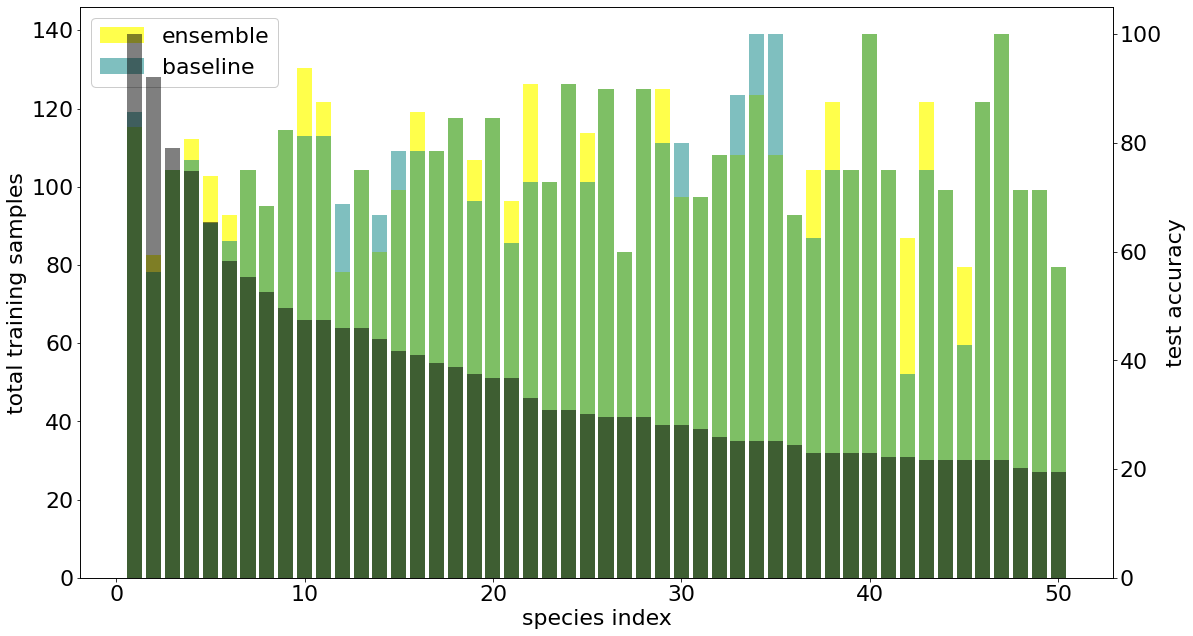

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

x = np.arange(1, 180)[:50]
y1 = df['total'].to_numpy()[:50]
y2 = df['counts'].to_numpy()[:50]/df['total_test'].to_numpy()[:50]*100
y3 = df['counts_baseline'].to_numpy()[:50]/df['total_test'].to_numpy()[:50]*100

fig, ax1 = plt.subplots()

fig.set_size_inches(18.5, 10.5)

ax2 = ax1.twinx()
ax1.bar(x, y1, color = 'black', alpha = 0.5, label = 'species count')
ax2.bar(x, y2, color = 'yellow', alpha = 0.7, label = 'ensemble')
ax2.bar(x, y3, color = 'teal', alpha = 0.5, label = 'baseline')

ax1.set_xlabel('species index')
ax1.set_ylabel('total training samples')
ax2.set_ylabel('test accuracy')

ax1.set_zorder(10)
ax1.patch.set_visible(False)



plt.legend(loc = 'best', framealpha= 1)
plt.show()

In [ ]:
common_species = df['species'][:50].to_numpy()

In [ ]:
with open('edible_mushrooms.txt') as f: 
  edibles = f.read().split('\n')

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(flat_labels, flat_results, pos_label=1)

In [ ]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.7710384737552609

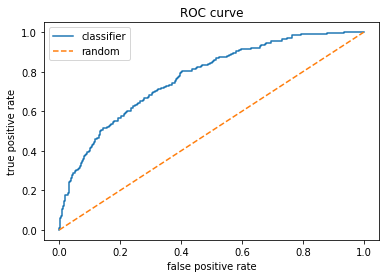

In [ ]:
from matplotlib import pyplot as plt

plt.plot(fpr, tpr, label = 'classifier')
plt.plot(fpr, fpr, '--', label = 'random')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(flat_labels, flat_results, pos_label=1)

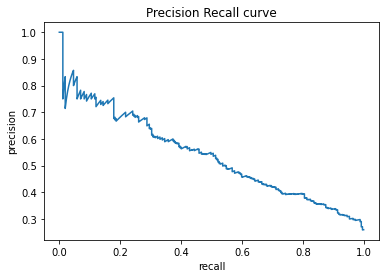

In [ ]:
from matplotlib import pyplot as plt

plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall curve")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(flat_labels, y_pred, average='binary')

(0.5454545454545454, 0.490272373540856, 0.5163934426229507, None)

In [ ]:

pred_results_dt = []
true_results_dt = []

for i in np.unique(leaves): 
  print('LEAF #', i)

  index = np.where(leaves == i)[0]
  sample = Xte[index, :]

  test_pred = clf.predict(sample)

  pred_results_dt.append(test_pred)

  y_true = Xste.iloc[index]['edibility'].to_numpy()
  true_results_dt.append(y_true)



LEAF # 6
LEAF # 9
LEAF # 10
LEAF # 13
LEAF # 14
LEAF # 16
LEAF # 17
LEAF # 21
LEAF # 22
LEAF # 24
LEAF # 25
LEAF # 31
LEAF # 32
LEAF # 37
LEAF # 38
LEAF # 39
LEAF # 40
LEAF # 44
LEAF # 47
LEAF # 48
LEAF # 54
LEAF # 56
LEAF # 57
LEAF # 59
LEAF # 61
LEAF # 62
LEAF # 65
LEAF # 67
LEAF # 68
LEAF # 72
LEAF # 74
LEAF # 75
LEAF # 80
LEAF # 81
LEAF # 84
LEAF # 85
LEAF # 88
LEAF # 90
LEAF # 91
LEAF # 92


In [ ]:
flat_results_dt = np.array([item for sublist in pred_results_dt for item in sublist])
flat_labels_dt = np.array([item for sublist in true_results_dt for item in sublist])

In [ ]:
y_pred_dt = (flat_results_dt > 0.5).astype(int) #convert to binary
y_pred_dt.shape

(1041,)

In [ ]:
missclass_dt = np.where(flat_labels_dt-y_pred_dt != 0)[0]
missclass_model = np.where(flat_labels-y_pred.reshape(-1) != 0)[0]

### Deleting images with no metadata

In [ ]:
#a = set(os.listdir(DATA_DIR))
#b = set(metadata_sorted['image_path'].values)

In [ ]:
#for filename in os.listdir(DATA_DIR):
#    if filename not in list(metadata_sorted['image_path'].values):
#        os.remove(os.path.join(DATA_DIR, filename))
#        print('file removed!')

In [ ]:
normalization_layer = layers.Rescaling(1./255)


data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
for images, labels in tf_train_dataset.take(1):
  print(images['pixel_values'][1], labels[1])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in tf_train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images['pixel_values'][i].astype("uint8"))
    ax.title(labels[i])
    plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")